In [2]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt
import pandas as pd
from pyro.optim import ClippedAdam
import json
from pyro.nn import PyroModule
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal
# from pyro.optim import ClippedAdam
# import pandas as pd
from sklearn.preprocessing import StandardScaler
# import sklearn.metrics.mean_absolute_percentage_error

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(20200305)


In [ ]:
games_df = pd.read_csv('games_filtered.csv')
att_df = pd.read_csv('attendance.csv')   

# Neural Gaussian Hidden Markov Model

In [ ]:
class TransitionNet(torch.nn.Module):
    def __init__(self, cov_dim, hidden_dim, scaling_factor):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.sc_fact = scaling_factor
        self.net = torch.nn.Sequential(
            torch.nn.Linear(cov_dim, 32),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(32),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(64),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(32),
            torch.nn.Linear(32, hidden_dim * hidden_dim)
        )

    def forward(self, x):
        x = self.net(x)
        batch_size = x.size(0)
        
        x = x.view(batch_size, self.hidden_dim, self.hidden_dim)
        temperature = 1.0  
        trans_matrix = torch.nn.functional.softmax(x/ temperature, dim=-1)  # Row-wise softmax for valid transition matrices
        return trans_matrix
class Model1(ForecastingModel):
    def __init__(self, cov_dim, hidden_dim=3, means_std=[0.0, 0.5, 0.5, 0.5, 5, 1]):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cov_dim = cov_dim
        self.trans_net = TransitionNet(cov_dim, hidden_dim, means_std[5])
        self.means_std = means_std

    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        
        batch_shape = zero_data.shape[:-2] 
        
        hidden_dim = self.hidden_dim

        other_covariates = covariates
        trans_mean_val = torch.tensor(self.means_std[0])
        trans_scale_val = torch.tensor(self.means_std[1])

        obs_matrix_scale_factor = self.means_std[4]
     
        prediction = torch.zeros_like(zero_data)
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(0.0, 0.5))
     
        trans_scale = trans_scale_val + 1e-3
     
        init_dist = dist.Normal(0, 1.0).expand(batch_shape + (hidden_dim,)).to_event(1)
        
        trans_mean = torch.full_like(trans_scale,trans_mean_val)
        trans_dist = dist.Normal(trans_mean, trans_scale_val).expand(batch_shape + (hidden_dim,)).to_event(1)
    
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(1, 0.2))  # Estimated from data
    
        batch_shape = obs_scale.shape[:-1]  # [N, T]
    
        obs_mean = torch.zeros_like(obs_scale)
        
        trans_logits = self.trans_net(other_covariates)  # [duration, hidden_dim * hidden_dim]
           
        trans_matrix_raw = trans_logits.view(duration, hidden_dim, hidden_dim)
    
        trans_matrix = trans_matrix_raw

    
        obs_matrix = obs_matrix_scale_factor*torch.eye(hidden_dim, 1).expand(*batch_shape, hidden_dim, 1)
        
        if batch_shape: # for forecasting
            trans_matrix = trans_matrix.unsqueeze(0).expand((batch_shape[0], duration, hidden_dim, hidden_dim))
            obs_matrix = torch.eye(hidden_dim, 1).reshape(1, 1, hidden_dim, 1)  
            obs_matrix = obs_matrix.expand(batch_shape[0], duration, hidden_dim, 1) 
            
            init_loc = torch.zeros(batch_shape[0], hidden_dim)  
            init_scale = torch.full((batch_shape[0], hidden_dim), 1.0)  
            init_dist = dist.Normal(init_loc, init_scale).to_event(1) 

            trans_loc = torch.full((batch_shape[0], duration, hidden_dim), trans_mean_val)
            trans_scale = torch.full((batch_shape[0], duration, hidden_dim), trans_scale)
            trans_dist = dist.Normal(trans_loc, trans_scale).to_event(1)

            obs_scale = obs_scale.view(batch_shape[0], 1, 1).expand(batch_shape[0], duration, 1)
            obs_mean = torch.zeros_like(obs_scale)
            
            
        else:
            obs_scale = obs_scale.view(1, 1).expand(duration, 1)  


        obs_dist = dist.Normal(obs_mean, obs_scale).to_event(1)
    
        noise_dist = dist.GaussianHMM(
            initial_dist=init_dist,
            transition_matrix=trans_matrix,
            transition_dist=trans_dist,
            observation_matrix=obs_matrix, 
            observation_dist=obs_dist,
            duration=duration
        )

        self.predict(noise_dist, prediction)


# Train and Forecast model

In [ ]:
# load predictions from bayesian state-space model
predictions = {'49ers': [69494.25, 70472.95, 71532.516, 67405.875, 69431.28, 67417.69, 68187.47, 68095.4, 68446.695, 69705.266, 68714.89, 69383.44, 67117.164, 69247.86, 68395.914, 71139.84], 'Bears': [61061.51, 61333.07, 63162.477, 60973.04, 62049.805, 63943.383, 62977.156, 60614.914, 62793.46, 61331.023, 64430.234, 63333.08, 60894.72, 61710.387, 62089.18, 65659.35], 'Bengals': [55362.223, 55110.33, 56658.36, 55709.098, 57243.266, 54570.746, 53674.01, 53352.24, 53144.95, 51040.812, 52583.883, 54428.605, 52975.11, 50627.688, 54861.375, 52171.15], 'Bills': [67080.945, 67521.77, 68740.93, 65874.734, 68087.305, 66092.484, 66456.16, 65488.324, 65182.26, 66725.16, 65418.64, 66831.66, 64405.04, 64938.742, 66490.56, 63255.48], 'Broncos': [73866.64, 73751.77, 76309.055, 74940.445, 73717.5, 74979.25, 75538.734, 73118.28, 75103.375, 74056.75, 73701.06, 78439.48, 74518.125, 74991.05, 73891.31, 73860.47], 'Browns': [64151.93, 62614.81, 62792.56, 64972.54, 64227.707, 62980.65, 63380.863, 62562.902, 66499.26, 68759.516, 66139.42, 64448.312, 66223.59, 65182.047, 64533.086, 65919.18], 'Buccaneers': [62295.402, 62181.06, 59433.16, 60028.586, 59229.812, 60383.312, 62110.242, 59997.465, 55301.28, 55549.754, 61737.457, 53057.0, 56960.76, 56350.043, 56316.28, 55452.125], 'Cardinals': [64549.98, 63406.94, 63313.95, 66166.38, 64197.797, 63620.125, 64074.99, 64963.812, 61389.566, 62443.06, 62887.0, 63210.734, 63214.58, 63375.77, 61641.76, 60824.21], 'Chargers': [32482.36, 30964.754, 30838.062, 38636.684, 31357.95, 30391.23, 29963.562, 32913.203, 38442.195, 38586.375, 37456.523, 40033.64, 36386.223, 40076.91, 37136.164, 36665.004], 'Chiefs': [74211.195, 75298.26, 73836.375, 73932.36, 73553.95, 72842.02, 73405.12, 71264.4, 76424.77, 78688.1, 76524.555, 77065.76, 74701.46, 73061.33, 74511.56, 76051.01], 'Colts': [64164.742, 64973.266, 63316.367, 65354.363, 64150.902, 64363.61, 62151.652, 63147.32, 60769.58, 60709.56, 61428.133, 60581.41, 59507.734, 58782.234, 59339.57, 58590.77], 'Cowboys': [89729.14, 89176.82, 89203.59, 90144.195, 87791.55, 90690.625, 90546.44, 88981.01, 87592.99, 87902.22, 89267.555, 89597.61, 90152.0, 86227.27, 87928.92, 85929.984], 'Dolphins': [67029.46, 67277.64, 66488.72, 67750.945, 66018.016, 66483.36, 67685.91, 67739.82, 66580.414, 68516.836, 66808.984, 64734.07, 64601.734, 66417.41, 65640.45, 64600.72], 'Eagles': [70282.836, 68416.72, 69957.664, 69902.984, 71027.82, 68216.28, 68467.45, 69503.16, 68830.79, 68998.83, 68279.695, 69626.164, 71082.91, 70605.06, 68245.88, 68440.95], 'Falcons': [71597.586, 73332.766, 70911.734, 71125.375, 71398.05, 71419.98, 70011.5, 69269.59, 74507.76, 71840.53, 74706.81, 73015.516, 73963.83, 73935.43, 71532.57, 70805.625], 'Giants': [76603.555, 77206.72, 78738.61, 75386.38, 75569.0, 74481.586, 75918.34, 75200.21, 75064.516, 74566.57, 76589.91, 74912.38, 76761.34, 75301.234, 73840.4, 76144.04], 'Jaguars': [65034.316, 65053.8, 63621.125, 64578.63, 72342.26, 65181.42, 61851.383, 63781.105, 70393.555, 66796.914, 69893.945, 67895.91, 75600.01, 68199.25, 69032.016, 68106.016], 'Jets': [75706.19, 74730.71, 74608.19, 78109.99, 76237.805, 76461.945, 75598.305, 74727.72, 75429.516, 76361.86, 76029.59, 78747.18, 76087.586, 74717.11, 75375.516, 75730.4], 'Lions': [65935.75, 66996.01, 63860.97, 65263.45, 64443.125, 68229.016, 65458.43, 65100.44, 64216.234, 66006.305, 64229.824, 62998.887, 64318.29, 68380.516, 63411.09, 62092.63], 'Packers': [76427.086, 77152.71, 75869.58, 77468.17, 75176.2, 75801.15, 76045.94, 76742.56, 76484.016, 76439.516, 78699.7, 77212.28, 76465.62, 76149.24, 75290.31, 76555.98], 'Panthers': [71850.1, 71931.91, 72594.3, 72933.07, 73136.664, 72624.195, 72521.3, 71998.2, 74178.836, 73371.81, 73183.945, 72205.78, 73198.74, 70950.41, 71866.25, 74102.625], 'Patriots': [67271.9, 64986.13, 65081.156, 69392.984, 67300.05, 65916.45, 65912.89, 63615.14, 67198.34, 66110.26, 66572.28, 66891.19, 65999.0, 67771.35, 64693.777, 65394.9], 'Raiders': [64459.434, 57488.613, 59124.645, 57987.605, 57800.434, 58510.4, 58455.434, 57916.754, 63449.156, 61153.64, 59912.598, 58069.703, 60143.0, 58247.41, 58122.73, 57285.348], 'Rams': [63000.48, 63681.66, 65470.664, 64395.42, 64010.645, 65658.79, 67233.195, 62849.793, 72205.03, 74287.07, 72236.586, 71055.83, 73890.42, 73925.14, 73223.75, 69522.01], 'Ravens': [69726.69, 69673.18, 71850.3, 71027.14, 68990.59, 69336.71, 69727.5, 69256.79, 68892.375, 70953.516, 69810.76, 73672.1, 70433.51, 69914.23, 69406.97, 70066.64], 'Redskins': [73419.2, 72659.27, 74471.91, 73919.61, 75572.21, 73969.03, 72627.07, 75518.88, 62054.305, 63288.67, 64473.945, 62221.52, 62019.004, 61112.746, 62497.97, 61308.715], 'Saints': [73095.02, 71817.29, 73203.305, 73921.234, 73415.32, 73405.984, 72841.97, 73848.805, 73801.71, 74140.4, 73468.07, 71582.39, 73571.8, 73171.61, 72899.89, 72526.445], 'Seahawks': [67457.98, 70485.92, 68745.766, 68085.45, 67186.984, 69133.16, 70533.875, 68273.09, 68967.91, 71503.26, 71685.625, 71707.61, 70215.23, 69591.48, 67216.02, 69767.96], 'Steelers': [65205.863, 64505.617, 63416.7, 62893.598, 63841.945, 64509.562, 62429.383, 61173.684, 64138.516, 62650.566, 65083.016, 64103.184, 65040.773, 65128.355, 63375.1, 63952.234], 'Texans': [69844.44, 71923.28, 71391.305, 71469.62, 71814.734, 70272.26, 69701.89, 70236.41, 70589.1, 72157.74, 71936.31, 71356.95, 72836.734, 74112.195, 71251.28, 70941.59], 'Titans': [65465.59, 67742.58, 66157.56, 66344.516, 64326.934, 65216.113, 65885.33, 65968.234, 66523.95, 64569.57, 65775.43, 66111.49, 66876.81, 63774.6, 65833.35, 66733.5], 'Vikings': [66922.414, 68215.46, 66621.14, 71173.59, 66979.01, 67825.42, 65174.863, 65812.734, 66615.734, 65732.17, 67731.19, 66946.586, 66795.46, 65877.766, 66737.56, 67557.57]}

In [ ]:
%%time
teams = games_df['home_team_name'].unique()
df_res = pd.DataFrame(columns=['team', 'rmse_loss_linear', 'rmse_loss_hmm', 'rmse_loss_bsl',
       'mae_loss_linear', 'mae_loss_hmm', 'mae_loss_bsl', 'lin_loss_mape',
       'hmm_loss_mape', 'bsl_loss_mape'])
test_year = 2018
for team in teams:
       home_df = games_df.loc[(games_df['home_team_name'] == team)]
       train_df = home_df.loc[(home_df['year'] < test_year)]
       test_and_context_df = home_df.loc[(home_df['year'] >= test_year-1)]
       
       pyro.set_rng_seed(1)
       pyro.clear_param_store()
       covariates = train_df[['home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
              'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
              'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
              'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
              'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
              'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
              'late_afternoon', 'evening']]
       
       covariates.loc[:,['noon', 'mid_afternoon',
              'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates[['noon', 'mid_afternoon',
              'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

       covariates_tensor = torch.tensor(covariates.values, dtype=torch.float)

       y = train_df.loc[train_df.index, 'weekly_attendance']-train_df['avg_season_attendance_prev']
       y_tensor = torch.tensor(y.values, dtype=torch.float).unsqueeze(-1)

       mean_val = y_tensor.mean()
       std_val = y_tensor.std()

       zero_data = (y_tensor - mean_val) / std_val

       forecaster = Forecaster(Model1(cov_dim=26, hidden_dim=9), zero_data, covariates_tensor, learning_rate=0.1, learning_rate_decay=0.01, num_steps=500)
       for name, value in forecaster.guide.median().items():
              if value.numel() == 1:
                     print("{} = {:0.4g}".format(name, value.item()))

# Forecasting
    
       covariates_test = test_and_context_df[['home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season',
              'home_team_wins_last_3', 'away_team_wins_last_3', 'pts_home',
              'pts_away', 'yds_home', 'yds_away', 'turnovers_home', 'turnovers_away',
              'zscore_pts_home', 'zscore_yds_home', 'zscore_turnovers_home',
              'zscore_pts_away', 'zscore_yds_away', 'zscore_turnovers_away',
              'day_sin', 'day_cos', 'month_sin', 'month_cos', 'noon', 'mid_afternoon',
              'late_afternoon', 'evening']]
       
       covariates_test.loc[:,['noon', 'mid_afternoon',
              'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season']] = covariates_test[['noon', 'mid_afternoon',
              'late_afternoon', 'evening', 'home_team_superbowl_winner_last_season',
              'away_team_superbowl_winner_last_season',
              'home_team_playoffs_last_season', 'away_team_playoffs_last_season']].astype('int')

       covariates_test_tensor = torch.tensor(covariates_test.values, dtype=torch.float)

       y_context = test_and_context_df.loc[test_and_context_df['year']<test_year, 'weekly_attendance']
       y_context_tensor = torch.tensor(y_context.values, dtype=torch.float).unsqueeze(-1)

       samples = forecaster(y_context_tensor, covariates_test_tensor, num_samples=100)
       p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
       y_test = test_and_context_df.loc[test_and_context_df['year']>=test_year, 'weekly_attendance']
       y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).unsqueeze(-1)
       last_year = test_and_context_df.loc[test_and_context_df['year']>=test_year, 'avg_season_attendance_prev']
    
       p50 = p50*std_val+mean_val+torch.tensor(last_year.values, dtype=torch.float)
       crps = eval_crps(samples, y_test_tensor)
       team = train_df['home_team_name'].iloc[0]
       preds_linear = torch.tensor(predictions[team])

# losses computation

       mae_loss = torch.nn.L1Loss()
       mseloss = torch.nn.MSELoss()

       mae_loss_linear = mae_loss(preds_linear, y_test_tensor)
       print("MAE linear model: ", mae_loss_linear.item())
       mae_loss_hmm = mae_loss(p50, y_test_tensor)
       print("MAE with HMM+NN: ", mae_loss_hmm.item())
       mae_loss_bsl = mae_loss(torch.tensor(last_year.values), y_test_tensor)
       print("MAE with last year mean: ", mae_loss_bsl.item())


       lin_loss_mape = torch.mean(torch.abs(preds_linear.view(16,1)-y_test_tensor)/y_test_tensor)
       
       print("MAPE linear model ", lin_loss_mape.item()*100)
       hmm_loss_mape = torch.mean(torch.abs(p50.view(16,1)-y_test_tensor)/y_test_tensor)
       print("MAPE HMM+NN ", hmm_loss_mape.item()*100)
       bsl_loss_mape = torch.mean(torch.abs(torch.tensor(last_year.values).view(16,1)-y_test_tensor)/y_test_tensor)
       print("MAPE Baseline ", bsl_loss_mape.item()*100)
       
       rmse_loss_linear = torch.sqrt(mseloss(preds_linear, y_test_tensor))
       print("RMSE linear model: ", rmse_loss_linear.item())
       rmse_loss_hmm = torch.sqrt(mseloss(p50, y_test_tensor))
       print("RMSE with HMM+NN: ", rmse_loss_hmm.item())

       rmse_loss_bsl = torch.sqrt(mseloss(torch.tensor(last_year.values), y_test_tensor))
       print("RMSE with last year mean: ", rmse_loss_bsl.item())

       filename= "./results/results_sp.json"
       data = {"team": team, "rmse_loss_linear": float(rmse_loss_linear.item()), "rmse_loss_hmm": float(rmse_loss_hmm.item()), "rmse_loss_bsl": float(rmse_loss_bsl.item()), "mae_loss_linear": float(mae_loss_linear.item()), "mae_loss_hmm": float(mae_loss_hmm.item()), "mae_loss_bsl": float(mae_loss_bsl.item()), "lin_loss_mape": float(lin_loss_mape.item()*100), "hmm_loss_mape": float(hmm_loss_mape.item()*100), "bsl_loss_mape": float(bsl_loss_mape.item()*100)}
      
       df_res = pd.concat([df_res, pd.DataFrame([data])], ignore_index=True)

       
       x = list(range(16))
       
       location = att_df.loc[att_df['team_name'] == team, 'team'].iloc[0]
       plt.figure(figsize=(10, 5))  

       # HMM State-space - light red
       plt.plot(x, p50, 
              color=(255/255, 100/255, 100/255, 0.7), 
              linewidth=2,
              marker='o',
              markersize=5)

       # Bayesian State-space - light blue
       plt.plot(x, preds_linear, 
              color=(100/255, 100/255, 255/255, 0.7), 
              linewidth=2,
              marker='o',
              markersize=5)

       # Ground truth - soft black/gray
       plt.plot(x, y_test.values, 
              color=(50/255, 50/255, 50/255, 0.8), 
              linewidth=2,
              marker='o',
              markersize=5)

       # Baseline - green
       plt.plot(x, last_year.values, 
              color='green', 
              linewidth=2,
              marker='o',
              markersize=5)

       # Title and labels with custom fonts
       plt.title(f"Attendance {location} {team}", 
              fontsize=20, 
              fontfamily='Arial')

       plt.xlabel("Seasons", 
              fontsize=18, 
              color='black')
       plt.ylabel("People", 
              fontsize=18, 
              color='black')

       # Custom x-ticks
       plt.xticks(ticks=[0, 8], 
              labels=["S2018", "S2019"],
              fontsize=14,
              color='black')

       # Y-axis ticks
       plt.yticks(fontsize=14, 
              color='black')

       # Axis styling
       ax = plt.gca()
       ax.spines['bottom'].set_color('black')
       ax.spines['bottom'].set_linewidth(2)
       ax.spines['left'].set_color('black')
       ax.spines['left'].set_linewidth(2)
       ax.spines['top'].set_visible(False)
       ax.spines['right'].set_visible(False)

       # White background
       plt.style.use('default')
       ax.set_facecolor('white')

       plt.tight_layout()

    #    Results storing
       # plt.savefig(f"../plots/{team}.png")

# results storing
df_res.to_csv("results_df.csv", index=False)


# Bayesian State‐space Model

Using device: cuda
Step    0  ELBO per point = 6891.0320
Step  200  ELBO per point = 2951.3765
Step  400  ELBO per point = 2014.9132
Step  600  ELBO per point = 1899.3511
Step  800  ELBO per point = 1776.2069
Step 1000  ELBO per point = 1756.2409
Step 1200  ELBO per point = 1756.3810
Step 1400  ELBO per point = 1758.5678
Step 1600  ELBO per point = 1746.3157
Step 1800  ELBO per point = 1741.5980


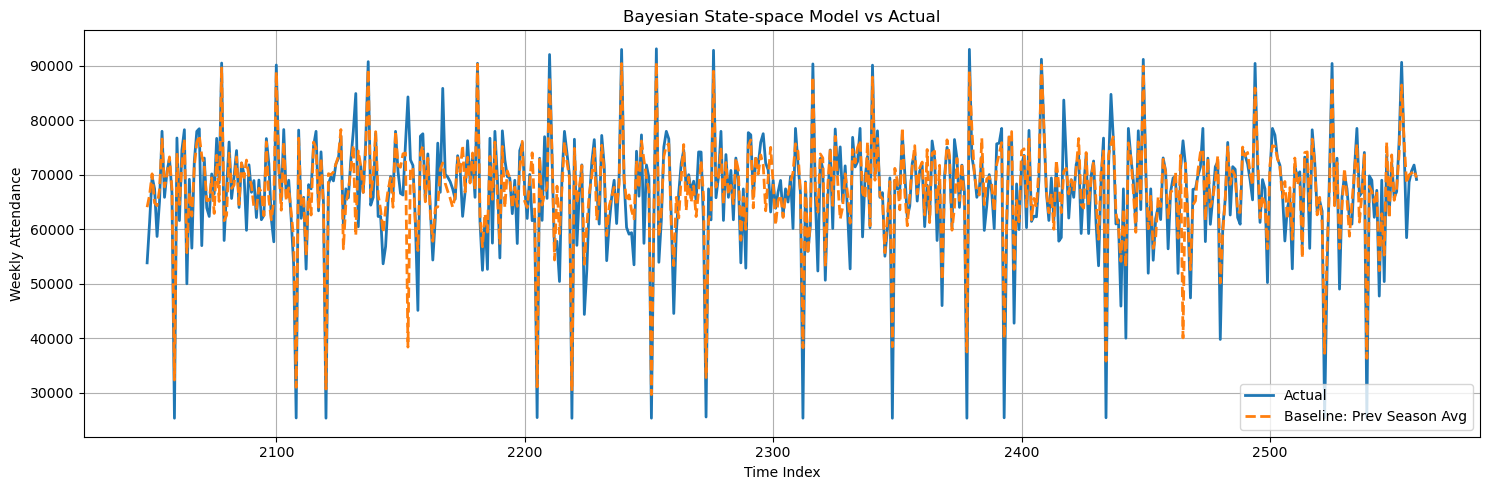

In [3]:

# Load and clean the data
df = pd.read_csv("games_filtered.csv")
features = [
    "away_team_superbowl_winner_last_season",
    "home_team_playoffs_last_season",
    "away_team_playoffs_last_season",
    "home_team_wins_last_3",
    "away_team_wins_last_3",
    'pts_home','pts_away','yds_home','yds_away',
    'turnovers_home','turnovers_away',
    'zscore_pts_home','zscore_yds_home','zscore_turnovers_home',
    'zscore_pts_away','zscore_yds_away','zscore_turnovers_away',
    'day_sin','day_cos','month_sin','month_cos',
    'noon','mid_afternoon','late_afternoon','evening'
]

impute_cols = features + [
    "avg_season_attendance_prev",
    "prev_game_attendance",
    "weekly_attendance"
]

# 3. Mean‐impute missing values
df[impute_cols] = df[impute_cols].fillna(df[impute_cols].mean())

# Fit StandardScalers to each set of columns
scaler_x    = StandardScaler().fit(df[features])
scaler_avg  = StandardScaler().fit(df[["avg_season_attendance_prev"]])
scaler_prev = StandardScaler().fit(df[["prev_game_attendance"]])
scaler_y    = StandardScaler().fit(df[["weekly_attendance"]])

# Transform to tensors (will move to GPU if available later)
x_all    = torch.tensor(scaler_x.transform(df[features]), dtype=torch.float32)
avg_all  = torch.tensor(scaler_avg.transform(df[["avg_season_attendance_prev"]])[:,0],
                        dtype=torch.float32)
prev_all = torch.tensor(scaler_prev.transform(df[["prev_game_attendance"]])[:,0],
                        dtype=torch.float32)
y_all    = torch.tensor(scaler_y.transform(df[["weekly_attendance"]])[:,0],
                        dtype=torch.float32)

# Split into training and test sets (80/20)
N     = y_all.size(0)
split = int(0.8 * N)
x_train, x_test       = x_all[:split],    x_all[split:]
avg_train, avg_test   = avg_all[:split],  avg_all[split:]
prev_train, prev_test = prev_all[:split], prev_all[split:]
y_train, y_test       = y_all[:split],    y_all[split:]

# Select device better works on DTU HPU training is very slow otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Move training tensors to the chosen device
x_train   = x_train.to(device)
avg_train = avg_train.to(device)
prev_train= prev_train.to(device)
y_train   = y_train.to(device)

# Define the state-space model in PyroModule
class AttendanceModel(PyroModule):
    def __init__(self, num_features, seq_len):
        super().__init__()
        self.num_features = num_features
        self.seq_len      = seq_len

    def model(self, obs, feat, avg, prev):
        """
        obs:      Tensor of shape (T,) containing observed attendances
        feat:     Tensor of shape (T, F) of game-related covariates
        avg:      Tensor of shape (T,) of season-average attendance
        prev:     Tensor of shape (T,) of previous-game attendance
        """
        dev = obs.device

        # Hierarchical half-Cauchy prior for noise scales
        sigma0     = pyro.sample("sigma0",     dist.HalfCauchy(torch.tensor(5.0, device=dev)))
        proc_noise = pyro.sample("proc_noise", dist.HalfCauchy(sigma0))
        meas_noise = pyro.sample("meas_noise", dist.HalfCauchy(sigma0))

        # Intercept prior
        intercept = pyro.sample(
            "intercept",
            dist.Normal(torch.tensor(0.0, device=dev), torch.tensor(10.0, device=dev))
        )

        # AR(1) coefficient constrained to [-1, 1] via a Beta→linear transform
        raw_ar   = pyro.sample("raw_ar", dist.Beta(2.0, 2.0))
        ar_coef  = 2.0 * raw_ar - 1.0

        # Season-average effect prior (tight Normal around 1.0)
        avg_coef = pyro.sample("avg_coef", dist.Normal(1.0, 0.1))

        # Feature coefficients with Laplace (double-exponential) shrinkage
        feat_coefs = pyro.sample(
            "feat_coefs",
            dist.Laplace(loc=torch.zeros(self.num_features, device=dev),
                         scale=torch.tensor(1.0, device=dev))
            .to_event(1)
        )

        # Build latent means vector mu_z for each time step
        # We start latent state with the previous-game attendance
        z0     = prev[:1]
        z_prev = torch.cat([z0, torch.zeros(self.seq_len - 1, device=dev)])
        mu_z   = (
            intercept
            + ar_coef * z_prev
            + avg_coef * avg
            + (feat * feat_coefs).sum(-1)
        )

        # Sample latent states and observations in parallel over time
        with pyro.plate("time", self.seq_len):
            z = pyro.sample("z", dist.Normal(mu_z, proc_noise).to_event(1))
            pyro.sample("y", dist.Normal(z, meas_noise).to_event(1), obs=obs)

# Instantiate and run SVI(tried from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps, not working)
model = AttendanceModel(x_train.size(1), x_train.size(0)).to(device) # Move model to device
guide = AutoNormal(model.model) # Auto guide for variational inference
optim = ClippedAdam({"lr": 0.005, "clip_norm": 5.0})
svi   = SVI(model.model, guide, optim, loss=Trace_ELBO()) # Set up SVI with Trace_ELBO loss

for step in range(2000):
    loss = svi.step(y_train, x_train, avg_train, prev_train)
    if step % 200 == 0:
        print(f"Step {step:4d}  ELBO per point = {loss / y_train.size(0):.4f}")

# Extract posterior medians for parameters
q            = guide.quantiles([0.5]) # Get posterior quantiles
intercept_pt = q["intercept"][0].cpu() # Extract intercept
ar_coef_pt   = (2 * q["raw_ar"][0] - 1.0).cpu() # Transform raw AR coefficient to [-1, 1] range
avg_coef_pt  = q["avg_coef"][0].cpu() # Extract average coefficient
feat_coefs_pt= q["feat_coefs"].cpu() # Extract feature coefficients

# One-step-ahead forecasting on the test set (CPU)
x_test_cpu      = x_test
avg_test_cpu    = avg_test
prev_train_cpu  = prev_train.cpu()
test_len        = y_test.size(0)

z_prev = prev_train_cpu[-1].unsqueeze(0)
y_preds = []
for t in range(test_len):
    mu = (
        intercept_pt
        + ar_coef_pt * z_prev[-1]
        + avg_coef_pt * avg_test_cpu[t]
        + (feat_coefs_pt * x_test_cpu[t]).sum()
    )
    z_prev = torch.cat([z_prev, mu.unsqueeze(0)], dim=0)
    y_preds.append(mu)

y_preds     = torch.stack(y_preds).numpy()
y_pred_orig = scaler_y.inverse_transform(y_preds.reshape(-1,1))[:,0] # Inverse transform(strandarization) to original scale
actual_orig = scaler_y.inverse_transform(y_test.numpy().reshape(-1,1))[:,0] # Inverse transform(strandarization) to original scale


plt.figure(figsize=(15, 5))

plt.plot(range(split, N), actual_orig,
         label="Actual", linewidth=2)


plt.plot(range(split, N), y_pred_orig,
         label="Baseline: Prev Season Avg",
         linestyle="--", linewidth=2)

plt.xlabel("Time Index")
plt.ylabel("Weekly Attendance")
plt.title("Bayesian State‐space Model vs Actual")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Baseline

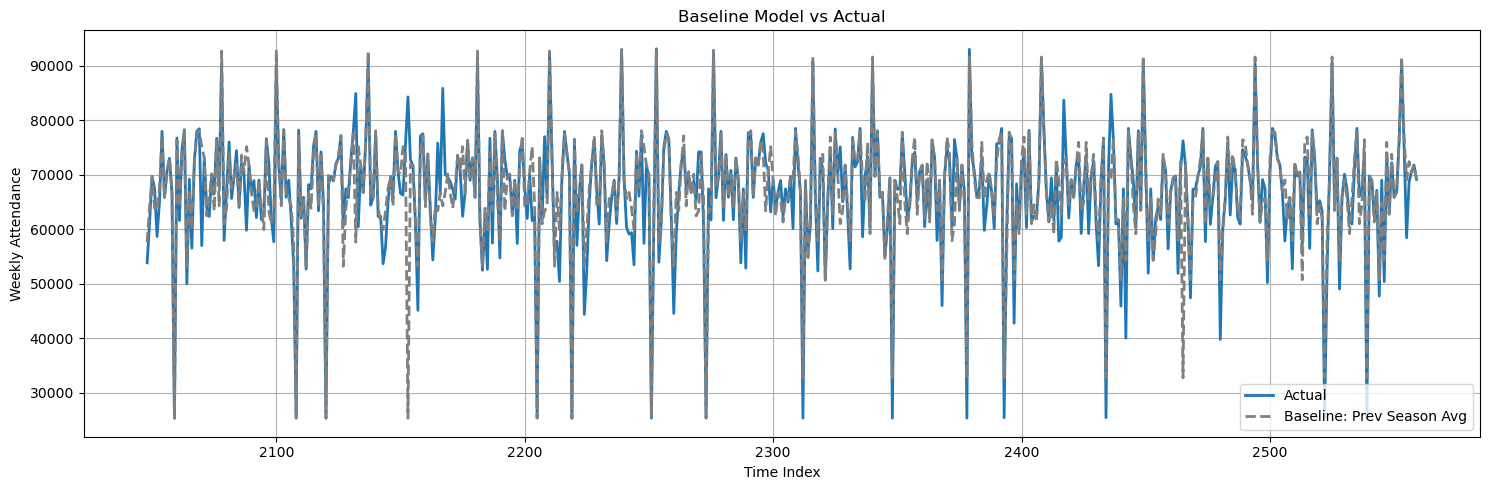

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(range(split, N), actual_orig,
         label="Actual", linewidth=2)

baseline = df["avg_season_attendance_prev"].values[split:N]
plt.plot(range(split, N), baseline,
         label="Baseline: Prev Season Avg", color="gray",
         linestyle="--", linewidth=2)

plt.xlabel("Time Index")
plt.ylabel("Weekly Attendance")
plt.title("Baseline Model vs Actual")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
